Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
FastCIFARNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): DepthwiseSeparableConv(
        (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): DepthwiseSeparableConv(
        (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

/tmp/ipython-input-3556527638.py:175: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # 混合精度训练
/tmp/ipython-input-3556527638.py:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/50], Step [10/98], Loss: 1.9992
Epoch [1/50], Step [20/98], Loss: 1.8740
Epoch [1/50], Step [30/98], Loss: 1.7522
Epoch [1/50], Step [40/98], Loss: 1.5828
Epoch [1/50], Step [50/98], Loss: 1.5586
Epoch [1/50], Step [60/98], Loss: 1.5524
Epoch [1/50], Step [70/98], Loss: 1.4769
Epoch [1/50], Step [80/98], Loss: 1.3996
Epoch [1/50], Step [90/98], Loss: 1.4158
Epoch [1/50] completed in 9.90s
Training Loss: 1.6490, Test Accuracy: 50.71%
Epoch [2/50], Step [10/98], Loss: 1.3458
Epoch [2/50], Step [20/98], Loss: 1.2837
Epoch [2/50], Step [30/98], Loss: 1.2342
Epoch [2/50], Step [40/98], Loss: 1.2937
Epoch [2/50], Step [50/98], Loss: 1.1973
Epoch [2/50], Step [60/98], Loss: 1.1075
Epoch [2/50], Step [70/98], Loss: 1.1821
Epoch [2/50], Step [80/98], Loss: 1.0809
Epoch [2/50], Step [90/98], Loss: 1.1562
Epoch [2/50] completed in 10.00s
Training Loss: 1.2043, Test Accuracy: 57.99%
Epoch [3/50], Step [10/98], Loss: 1.0568
Epoch [3/50], Step [20/98], Loss: 0.9519
Epoch [3/50], Step [30/98

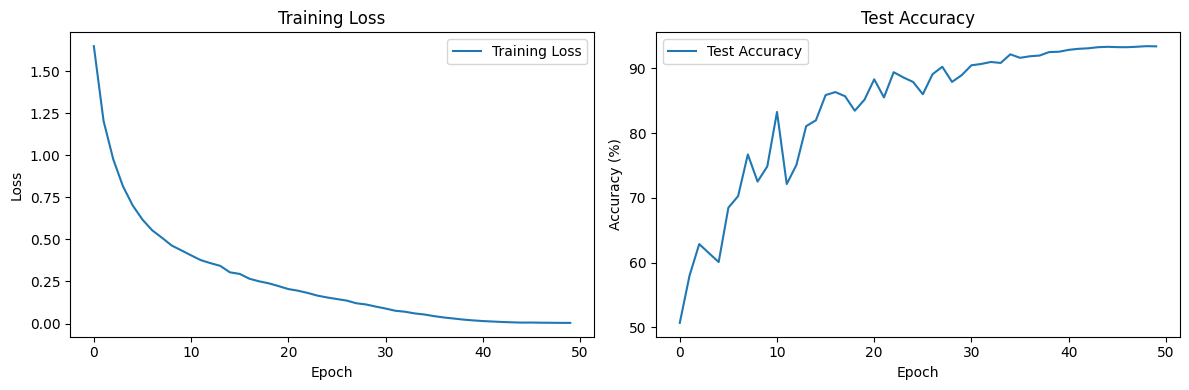

Model saved as fast_cifar_model.pth
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to Google Drive


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.cuda.amp import GradScaler, autocast

# set random seed
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"GPU: {torch.cuda.get_device_name(0)}")

# define model component
class SEBlock(nn.Module):
    """Squeeze-and-Excitation block"""
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class DepthwiseSeparableConv(nn.Module):
    """Depthwise separable convolution"""
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=False):
        super().__init__()
        self.depthwise = nn.Conv2d(
            in_channels, in_channels, kernel_size,
            stride, padding, groups=in_channels, bias=bias
        )
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class BasicBlock(nn.Module):
    """Basic residual block"""
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, use_se=False, use_ds=False):
        super().__init__()
        ConvLayer = DepthwiseSeparableConv if use_ds else nn.Conv2d

        self.conv1 = ConvLayer(
            in_channels, out_channels, kernel_size=3,
            stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = ConvLayer(
            out_channels, out_channels, kernel_size=3,
            stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

        self.se = SEBlock(out_channels) if use_se else nn.Identity()

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class FastCIFARNet(nn.Module):
    """Efficient CIFAR-10 classification model"""
    def __init__(self, block, num_blocks, num_classes=10, use_se=True, use_ds=True):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, use_se=use_se, use_ds=use_ds)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, use_se=use_se, use_ds=use_ds)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, use_se=use_se, use_ds=use_ds)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        self.channel_shuffle = nn.ChannelShuffle(groups=4)

    def _make_layer(self, block, out_channels, num_blocks, stride, use_se, use_ds):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(
                self.in_channels, out_channels, stride, use_se, use_ds
            ))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # Progressive image size training - Use a smaller size in the initial stage
        if self.training and x.size(2) > 32:
            x = F.interpolate(x, size=(32, 32), mode='bilinear', align_corners=False)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.channel_shuffle(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def create_model():
    """Create Model Instrance"""
    return FastCIFARNet(BasicBlock, [5, 5, 5]).to(device)

# Data loading and preprocessing
def get_data_loaders():
    #Data augmentation
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    # Download dataset
    train_set = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train)
    test_set = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)

    # Create Data loader
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=512, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=512, shuffle=False, num_workers=2)

    return train_loader, test_loader

# Training
def train_model(model, train_loader, test_loader, epochs=50):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scaler = GradScaler()

    # LR scheduler
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=epochs
    )

    train_losses = []
    test_accuracies = []

    total_start = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_start = time.time()
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Mixed-precision training
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            running_loss += loss.item()

            if i % 10 == 9:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        epoch_time = time.time() - epoch_start
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Evaluation
        test_acc = evaluate_model(model, test_loader)
        test_accuracies.append(test_acc)

        print(f'Epoch [{epoch+1}/{epochs}] completed in {epoch_time:.2f}s')
        print(f'Training Loss: {epoch_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

    total_time = time.time() - total_start
    print(f'Total training time: {total_time:.2f}s')
    print(f'Final accuracy: {test_accuracies[-1]:.2f}%')

    # Plot the curve
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

def main():
    train_loader, test_loader = get_data_loaders()

    model = create_model()
    # print(model)

    trained_model = train_model(model, train_loader, test_loader)

    torch.save(trained_model.state_dict(), 'fast_cifar_model.pth')
    print("Model saved as fast_cifar_model.pth")

    # from google.colab import drive
    # drive.mount('/content/drive')
    # torch.save(trained_model.state_dict(), '/content/drive/MyDrive/fast_cifar_model.pth')
    # print("Model saved to Google Drive")

if __name__ == '__main__':
    main()